# GAN para generar prendas de vestir

# En este notebook se implementa una GAN para generar prendas de vestir. La idea es que la GAN aprenda a generar imágenes de prendas de vestir a partir de un conjunto de datos de imágenes de prendas de vestir reales.

## Importar librerías

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

## Cargar datos

In [2]:
# Cargar Fashion MNIST
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

## Normalizar imágenes

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

## Definimos las Constantes

In [5]:
NUMBER_OF_IMAGES = 60000
BATCH_SIZE = 256

In [6]:
# Crear dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(NUMBER_OF_IMAGES).batch(BATCH_SIZE)

In [7]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Definimos el Generador

In [8]:
def build_generator():
    model = Sequential([
        Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        LeakyReLU(),
        Reshape((7, 7, 256)),  # Imagen inicial pequeña

        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        LeakyReLU(),

        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")  
    ])
    return model

generator = build_generator()


C:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Definimos el Discriminador

In [9]:
def build_discriminator():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1, activation="sigmoid")  # Salida 0 (falso) o 1 (real)
    ])
    return model

discriminator = build_discriminator()


C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Definimos la función de pérdida y los optimizadores

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)


## Entrenamiento de la GAN

C:\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


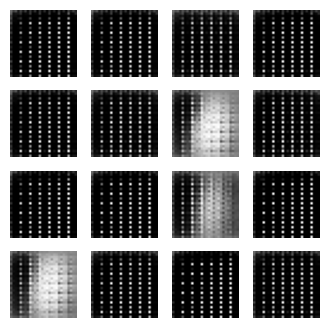

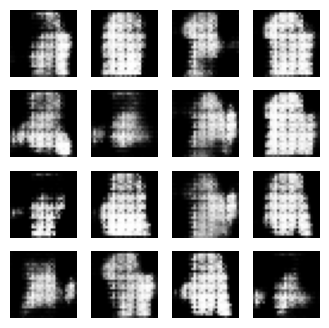

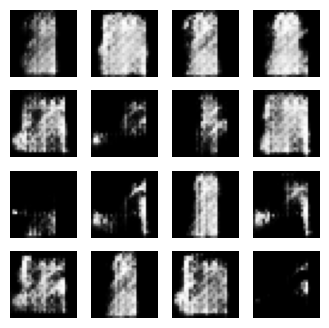

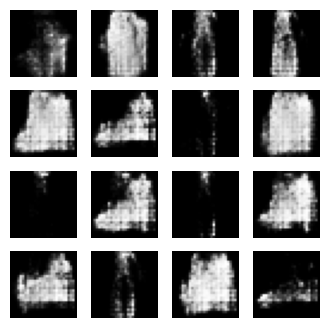

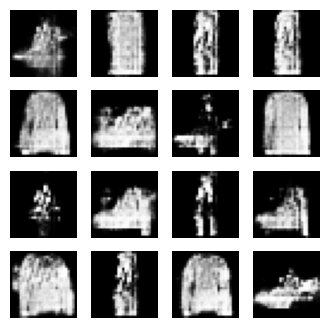

In [11]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Ruido fijo para visualizar resultados
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Función de entrenamiento
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

# Función para visualizar imágenes generadas
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
    plt.savefig(f"image_at_epoch_{epoch}.png")
    plt.show()

# Entrenar la GAN
train(train_dataset, EPOCHS)

## Guardamos el modelo

In [12]:
generator.save("generator_prendas_50ep.keras")
discriminator.save("discriminator_prendas_50ep.keras")

# Vamos a probar a generar una prenda

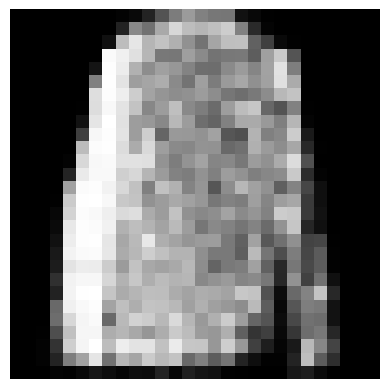

In [25]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0] * 127.5 + 127.5, cmap="gray")
plt.axis("off")
plt.show()